In [ ]:
import sys
import os
import requests
import subprocess
import shutil
from logging import getLogger, StreamHandler, INFO


logger = getLogger(__name__)
logger.addHandler(StreamHandler())
logger.setLevel(INFO)


def install(
        chunk_size=4096,
        file_name="Miniconda3-latest-Linux-x86_64.sh",
        url_base="https://repo.continuum.io/miniconda/",
        conda_path=os.path.expanduser(os.path.join("~", "miniconda")),
        rdkit_version=None,
        add_python_path=True,
        force=False):
    """install rdkit from miniconda
    ```
    import rdkit_installer
    rdkit_installer.install()
    ```
    """

    python_path = os.path.join(
        conda_path,
        "lib",
        "python{0}.{1}".format(*sys.version_info),
        "site-packages",
    )

    if add_python_path and python_path not in sys.path:
        logger.info("add {} to PYTHONPATH".format(python_path))
        sys.path.append(python_path)

    if os.path.isdir(os.path.join(python_path, "rdkit")):
        logger.info("rdkit is already installed")
        if not force:
            return

        logger.info("force re-install")

    url = url_base + file_name
    python_version = "{0}.{1}.{2}".format(*sys.version_info)

    logger.info("python version: {}".format(python_version))

    if os.path.isdir(conda_path):
        logger.warning("remove current miniconda")
        shutil.rmtree(conda_path)
    elif os.path.isfile(conda_path):
        logger.warning("remove {}".format(conda_path))
        os.remove(conda_path)

    logger.info('fetching installer from {}'.format(url))
    res = requests.get(url, stream=True)
    res.raise_for_status()
    with open(file_name, 'wb') as f:
        for chunk in res.iter_content(chunk_size):
            f.write(chunk)
    logger.info('done')

    logger.info('installing miniconda to {}'.format(conda_path))
    subprocess.check_call(["bash", file_name, "-b", "-p", conda_path])
    logger.info('done')

    logger.info("installing rdkit")
    subprocess.check_call([
        os.path.join(conda_path, "bin", "conda"),
        "install",
        "--yes",
        "-c", "rdkit",
        "python=={}".format(python_version),
        "rdkit" if rdkit_version is None else "rdkit=={}".format(rdkit_version)])
    logger.info("done")

    import rdkit
    logger.info("rdkit-{} installation finished!".format(rdkit.__version__))


if __name__ == "__main__":
    install()

add /root/miniconda/lib/python3.7/site-packages to PYTHONPATH
python version: 3.7.10
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
installing miniconda to /root/miniconda
done
installing rdkit
done
rdkit-2020.09.1 installation finished!


In [ ]:
from rdkit import Chem 

In [ ]:
!pip install git+https://github.com/samoturk/mol2vec

  Cloning https://github.com/samoturk/mol2vec to /tmp/pip-req-build-ye2h0s9z
  Running command git clone -q https://github.com/samoturk/mol2vec /tmp/pip-req-build-ye2h0s9z
  Created wheel for mol2vec: filename=mol2vec-0.1-cp37-none-any.whl size=14028 sha256=3edcfeb0aeda01badbf2ea0ccfd8371178245b4bb59976319481969a832187ee
  Stored in directory: /tmp/pip-ephem-wheel-cache-wqpris8b/wheels/96/0f/2d/a1092b9677c96453dc244b209544cac61bc8b974cbffb50063
Successfully built mol2vec


In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import pandas as pd
df=pd.read_csv('/content/drive/MyDrive/Drug_Repurposing/supercompf (1).csv')

target=df['vina_score']
df2=df[['smiles']]
df2['mol'] = df2['smiles'].apply(lambda x: Chem.MolFromSmiles(x))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
df.head()

,Unnamed: 0,ind1,ind2,vina_score,Unnamed: 3,smiles,mol,carbonyl,carboxylic acid,primary amine,alcohol,ester,amide,acid halide,fluorine halide,chlorine halide,bromine halide,iodine halide,anhydride,ether,secondary amine,enamine,alene,vinyl,phenol,fluorine,chlorine,Bromine,Iodine
0,0,0,0,-10.6,ERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245df0>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0
1,1,1,1,-10.0,METERGOTAMINE,CC1(C(=O)N2C(C(=O)N3CCCC3C2(O1)O)CC4=CC=CC=C4)...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e40>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0
2,2,2,2,-9.9,ABBV-744,CCNC(=O)C1=CC2=C(N1)C(=O)N(C=C2C3=C(C=CC(=C3)C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245e90>,1,0,0,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0
3,3,3,3,-9.9,DERQUANTEL,CC1(C=COC2=C(O1)C=CC3=C2NCC34CC56CN7CCC(C7(CC5...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245ee0>,1,0,0,1,0,1,1,0,0,0,0,0,2,1,1,0,2,0,0,0,0,0
4,4,4,4,-9.9,MERGOCRIPTINE,CC1=C2CC3C(=CC(CN3C)C(=O)NC4(C(=O)N5C(C(=O)N6C...,<rdkit.Chem.rdchem.Mol object at 0x7f562a245f30>,3,0,0,1,0,3,3,0,0,0,0,0,1,0,0,0,2,0,0,0,0,0


In [ ]:
from gensim.models import word2vec
from mol2vec import features
from mol2vec import helpers
from mol2vec.features import mol2alt_sentence, mol2sentence, MolSentence, DfVec, sentences2vec
df2['sentence'] = df2.apply(lambda x: MolSentence(mol2alt_sentence(x['mol'], 1)), axis=1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
model = word2vec.Word2Vec.load('/content/drive/MyDrive/Drug_Repurposing/model_300dim.pkl')
import numpy as np
df2['mol2vec'] = [DfVec(x) for x in sentences2vec(df2['sentence'], model, unseen='UNK')]
X = np.array([x.vec for x in df2['mol2vec']])
y = target.values
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(9002, 100)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score
def evaluation(model, X_test, y_test):
    prediction = model.predict(X_test)
    mae = mean_absolute_error(y_test, prediction)
    mse = mean_squared_error(y_test, prediction,squared=False)
    r2_score_val = r2_score(y_test, prediction)
    
    plt.figure(figsize=(15, 10))
    plt.plot(prediction[:300], "red", label="prediction", linewidth=1.0)
    plt.plot(y_test[:300], 'green', label="actual", linewidth=1.0)
    plt.legend()
    plt.ylabel('Vina_score')
    plt.title("MAE {}, MSE {}".format(round(mae, 4), round(mse, 4)))
    plt.show()
    
    print('MAE score:', round(mae, 4))
    print('rMSE score:', round(mse,4))
    print('R2 score:', round(r2_score_val,4))

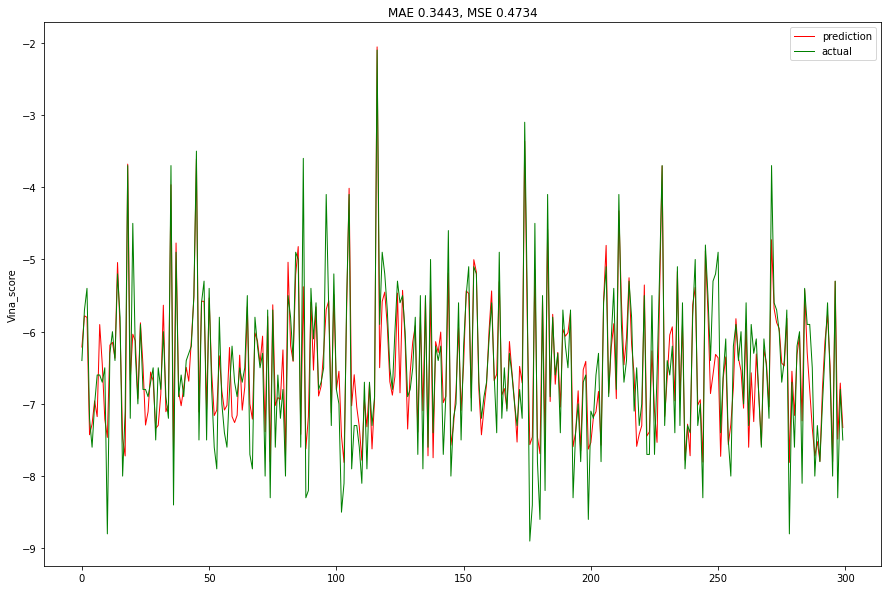

MAE score: 0.3443
rMSE score: 0.4734
R2 score: 0.8187


In [ ]:
 from sklearn.ensemble import RandomForestRegressor
 from sklearn.model_selection import train_test_split
 import matplotlib.pyplot as plt
 X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

regr = RandomForestRegressor(max_depth=7, random_state=1)
#cv = cross_validate(model, X, y, cv=5)
regr.fit(X, y)
evaluation(regr, X_test, y_test)

Github push

In [ ]:
!git init


Initialized empty Git repository in /content/.git/
